In [69]:
import tensorflow as tf
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from Energy_Models.Transformer import Transformer
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

In [73]:
df = pd.read_csv('../input/appliances-energy-prediction/KAG_energydata_complete.csv',parse_dates=['date'], index_col= 'date')

In [74]:
data = df.resample('D').sum() 

In [75]:
# resample the data on daily basis
df = df.resample('D').mean()
df.shape

(138, 28)

In [76]:
df

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11,136.666667,30.000000,20.808571,46.906210,20.153333,44.793175,20.140972,45.992440,19.492222,47.260813,...,16.918175,45.106210,5.922619,735.173810,89.285714,6.083333,40.845238,4.228571,26.248800,26.248800
2016-01-12,85.694444,4.236111,20.092326,45.142014,19.307655,43.779733,19.993646,44.933171,19.772778,44.556840,...,17.032847,45.680127,5.566319,742.628125,87.500000,5.784722,37.229167,3.596528,25.505072,25.505072
2016-01-13,97.013889,5.416667,19.197824,42.867772,18.568513,42.119669,19.609213,43.720891,19.009803,42.315174,...,16.953576,44.691476,4.856944,754.790625,83.406250,5.614583,31.559028,2.169792,23.464726,23.464726
2016-01-14,151.388889,5.000000,20.372078,42.435191,19.743131,40.699172,20.837581,43.399740,18.694271,43.231053,...,16.884815,45.428229,3.431944,749.767361,86.420139,6.277778,35.149306,1.316667,25.264569,25.264569
2016-01-15,125.347222,5.972222,22.280949,39.099294,21.528172,38.193897,20.959074,41.409884,19.615127,41.961036,...,17.345694,44.534329,2.665278,754.579861,88.385417,7.770833,40.208333,0.849653,26.289515,26.289515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-23,83.055556,2.013889,24.445046,47.025307,22.825978,47.749664,25.801574,42.977436,23.765955,45.311262,...,23.096240,46.394452,12.570486,755.849653,84.225694,4.208333,46.017361,9.851736,24.611743,24.611743
2016-05-24,96.180556,4.236111,24.299340,42.112535,22.617992,42.677685,25.368941,39.967807,23.869067,41.552216,...,22.765058,42.042955,11.568750,759.007292,76.680556,4.114583,33.975694,7.469097,25.494683,25.494683
2016-05-25,83.888889,2.569444,23.899353,38.929815,22.894673,38.182158,25.038329,38.137895,23.874266,38.582405,...,22.147823,39.681940,11.563542,756.887500,74.774306,1.350694,30.739583,6.819097,27.630188,27.630188


In [77]:
def train_test_split(df):
    
    # compute split point
    end_idx = df.shape[0]* 70 // 100
    
    train_data = df.iloc[:end_idx, : ]
    test_data = df.iloc[end_idx:, :]
    
    return train_data, test_data

In [78]:
# Split the data into train and test
X_train, X_test = train_test_split(df)

In [79]:
from sklearn.preprocessing import MinMaxScaler
def scale_data(train, test):
    scaler = MinMaxScaler().fit(train)
    return scaler.transform(train), scaler.transform(test), scaler

In [80]:
# Scale the data
X_train, X_test, scaler = scale_data(X_train, X_test)

In [81]:
def multivariate_splitter(df):

    input_features = []
    ouput_feature = []
    
    len_df = df.shape[0]
    
    for i in range(len_df):
        
        end_idx = i + 15
        
        if end_idx > len_df-15:
            break
            
        input_x , output_y = df[i:end_idx, 1:], df[end_idx: end_idx+15, 0]
        
        input_features.append(input_x)
        ouput_feature.append(output_y)
    
    return np.array(input_features), np.array(ouput_feature)

In [82]:
X_train, Y_train = multivariate_splitter(X_train)
X_test, Y_test = multivariate_splitter(X_test)
print('Shape of (training data) input features : %s and ouput feature %s' % (X_train.shape, Y_train.shape))
print('Shape of (testing data) input features : %s and ouput feature %s' % (X_test.shape, Y_test.shape))

Shape of (training data) input features : (67, 15, 27) and ouput feature (67, 15)
Shape of (testing data) input features : (13, 15, 27) and ouput feature (13, 15)


In [83]:
X_train.shape,Y_train.shape

((67, 15, 27), (67, 15))

In [84]:
input_shape = X_train.shape[1:]
model = Transformer(    
    input_shape,
    n_outputs=15,
    head_size=4,
    num_heads=4,
    ff_dim=32,
    num_transformer_blocks=10,
    mlp_units=[512],
    mlp_dropout=0.4,
    dropout=0.2,).build_model()

model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(),
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10)]

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 15, 27)]     0           []                               
                                                                                                  
 layer_normalization_60 (LayerN  (None, 15, 27)      54          ['input_4[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_30 (Multi  (None, 15, 27)      1803        ['layer_normalization_60[0][0]', 
 HeadAttention)                                                   'layer_normalization_60[0][0]'] 
                                                                                            

In [85]:
history=model.fit(
    X_train,
    Y_train,
    validation_split=0.3,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
)

Epoch 1/100
2/2 [==============================] - 15s 1s/step - loss: 0.8586 - val_loss: 0.2031
Epoch 2/100
2/2 [==============================] - 0s 89ms/step - loss: 0.2938 - val_loss: 0.1556
Epoch 3/100
2/2 [==============================] - 0s 78ms/step - loss: 0.2416 - val_loss: 0.1784
Epoch 4/100
2/2 [==============================] - 0s 76ms/step - loss: 0.1718 - val_loss: 0.1628
Epoch 5/100
2/2 [==============================] - 0s 77ms/step - loss: 0.1385 - val_loss: 0.1369
Epoch 6/100
2/2 [==============================] - 0s 82ms/step - loss: 0.1198 - val_loss: 0.1163
Epoch 7/100
2/2 [==============================] - 0s 108ms/step - loss: 0.1102 - val_loss: 0.1002
Epoch 8/100
2/2 [==============================] - 0s 86ms/step - loss: 0.0963 - val_loss: 0.0893
Epoch 9/100
2/2 [==============================] - 0s 84ms/step - loss: 0.0905 - val_loss: 0.0868
Epoch 10/100
2/2 [==============================] - 0s 84ms/step - loss: 0.0776 - val_loss: 0.0863
Epoch 11/100
2/2 [=

In [86]:
model.evaluate(X_train, Y_train, verbose=1)

3/3 [==============================] - 0s 14ms/step - loss: 0.0436


0.04361634701490402

In [87]:
model.evaluate(X_test, Y_test, verbose=1)

1/1 [==============================] - 0s 34ms/step - loss: 0.0650


0.06503254920244217

In [88]:
def print_metrics(model,Y_train,Y_pred_train,Y_test,Y_pred_test):
    print('Train MAE  value   : %.3f ' % mean_absolute_error(Y_train, Y_pred_train))
    print('Train MSE  value   : %.3f ' % mean_squared_error(Y_train, Y_pred_train))
    print('Train RMSE value   : %.3f ' % root_mean_squared_error(Y_train, Y_pred_train))
    print('Train R2   value   : %.3f ' % r2_score(Y_train, Y_pred_train))
    print('---------------------------------------------')
    print('Test  MAE  value   : %.3f ' % mean_absolute_error(Y_test, Y_pred_test))
    print('Test  MSE  value   : %.3f ' % mean_squared_error(Y_test, Y_pred_test))
    print('Test  RMSE value   : %.3f ' % root_mean_squared_error(Y_test, Y_pred_test))
    print('Test  R2   value   : %.3f ' % r2_score(Y_test, Y_pred_test))

In [89]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error, mean_absolute_percentage_error
def root_mean_squared_error(y_true, y_pred):    
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [90]:
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test) 

print("-" * 50)

print_metrics(model , Y_train , y_pred_train , Y_test , y_pred_test)

1/1 [==============================] - 0s 28ms/step
--------------------------------------------------
Train MAE  value   : 0.154 
Train MSE  value   : 0.044 
Train RMSE value   : 0.209 
Train R2   value   : -0.111 
---------------------------------------------
Test  MAE  value   : 0.213 
Test  MSE  value   : 0.065 
Test  RMSE value   : 0.255 
Test  R2   value   : -0.889 


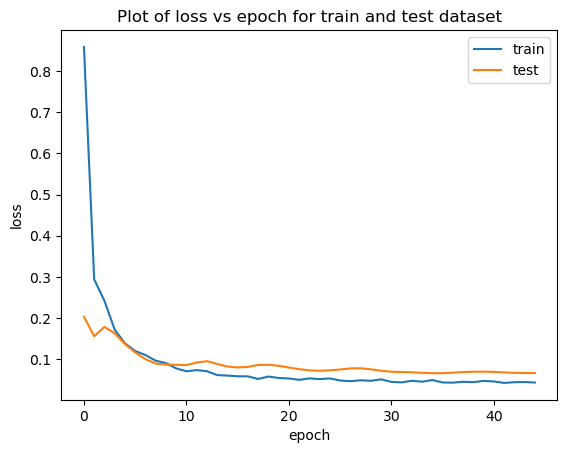

In [91]:
import matplotlib.pyplot as plt 
# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()